# Game of Clones

## Telling the rival Game of Thrones subreddits apart

Can Natural Language Processing combined with predictive models accurately distinguish between posts on <a href='https://www.reddit.com/r/pureasoiaf/'>`r/pureasoiaf/`</a> and <a href='https://www.reddit.com/r/freefolk/'>`r/freefolk/`</a>?

### ...Game of what? (Skip if you are familiar with GOT)

Game of Thrones, as in the multi-season, award-winning, fantasy <a href='https://www.hbo.com/game-of-thrones'>HBO series</a> based on the "A Song of Ice and Fire" novels by <a href='http://www.georgerrmartin.com'>George R. R. Martin</a>. Over 73 episodes of clashing armies, medieval politics, and fire-spewing dragons, noble houses with generations of enmity duke it out for the right to sit on the iron throne - the metaphorical and literal seat of power. Meanwhile, a large band of so-called Wildlings live outside the jurisdiction of the warring kingdoms, where the self-proclaimed freefolk contend with an ancient evil that will eventually threaten the existence of all living beings...  

### OK, what have we got?

Right, back to your regular programming. We will look at two subreddits dedicated to the TV series and books. <a href='https://www.reddit.com/r/pureasoiaf/'>`r/pureasoiaf/`</a> (a.k.a. Pure A Song of Ice and Fire) is dedicated solely to the novels and "does not allow content from the popular HBO series. Game of Thrones". As the TV series' plot development has overtaken that of the books and revealed the story's conclusion, book fans in `pureasoiaf` are exacting in ensuring they aren't contaminated by spoilers from the outside world. 

<a href='https://www.reddit.com/r/freefolk/'>`r/freefolk/`</a> live outside the jurisdiction of spoiler rules and declares that "we believe people are mature enough to decide for themselves what content to view".

### Goal

Let's see if a machine can identify the purists among the wider fan community. 

### Contents:
- [Data gathering from subreddits](#Data-gathering-from-subreddits)
- [Data cleaning and exploration](#Data-cleaning-and-exploration)
- [Modelling](#Modelling)
- [Logistic model analysis](#Logistic-model-analysis)
- [Conclusion](#Conclusion)

*All libraries used are added here*

In [413]:
#Imports:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid")

import requests
import time
import string
import spacy

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Data gathering from subreddits

### Use Reddit API to gather posts

#### Gather posts from `freefolk`

In [2]:
headers={'User-agent':'Peter Parker far from home'}#set header to prevent 429 status code

free_posts=[] #for storing of posts
after=None #so that param to be empty for the first iteration
for num in range(40): #range number will indicate how many pages of 25 posts to scrape
    if num % 10 == 0: #print whenever we are at 10th page
        print(num) #just to keep track that kernel is still runnning and how many pages we are at
    if after == None:
        param={} 
    else:
        param={'after':after}
    url = 'https://www.reddit.com/r/freefolk/.json'
    results = requests.get(url,params=param,headers=headers)
    if results.status_code==200: #to check if request successful
        d_json=results.json()
        free_posts.extend(d_json['data']['children']) 
        after=d_json['data']['after'] #so that after no longer == None and param={'after':after"} triggered 
    else:
        print(results.status_code)
        break
    time.sleep(1) #seconds to sleep

0
10
20
30


In [3]:
len(free_posts)

992

In [4]:
#check if posts are unique
len(set([post['data']['name'] for post in free_posts]))

992

We have 992 unique posts from `freefolk`.

In [5]:
#checking keys of each post
free_posts[0]['data'].keys()

dict_keys(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'thumbnail_height', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'author_flair_background_color', 'subreddit_type', 'ups', 'total_awards_received', 'media_embed', 'thumbnail_width', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'thumbnail', 'edited', 'author_flair_css_class', 'author_flair_richtext', 'gildings', 'content_categories', 'is_self', 'mod_note', 'created', 'link_flair_type', 'wls', 'banned_by', 'author_flair_type', 'domain', 'allow_live_comments', 'selftext_html', 'likes', 'suggested_sort', 'banned_at_utc', 'view_count', 'archived', 'no_follow', 'is_crosspostable', 

In [6]:
free_df = pd.DataFrame([post['data'] for post in free_posts])
free_df.head()

,all_awardings,allow_live_comments,approved_at_utc,approved_by,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_patreon_flair,banned_at_utc,banned_by,can_gild,can_mod_post,category,clicked,content_categories,contest_mode,created,created_utc,crosspost_parent,crosspost_parent_list,discussion_type,distinguished,domain,downs,edited,gilded,gildings,hidden,hide_score,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,likes,link_flair_background_color,link_flair_css_class,link_flair_richtext,link_flair_template_id,link_flair_text,...,media,media_embed,media_metadata,media_only,mod_note,mod_reason_by,mod_reason_title,mod_reports,name,no_follow,num_comments,num_crossposts,num_reports,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,pwls,quarantine,removal_reason,report_reasons,saved,score,secure_media,secure_media_embed,selftext,selftext_html,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,[],True,None,None,False,Im-not-Steve,None,None,[],None,None,None,text,t2_c54kv,False,None,None,False,False,None,False,None,False,1.563607e+09,1.563579e+09,NaN,NaN,None,None,self.freefolk,0,False,0,{},False,False,cfetu0,False,False,False,False,True,True,False,None,,None,[],NaN,None,...,None,{},NaN,False,None,None,None,[],t3_cfetu0,False,656,0,None,False,all_ads,/r/freefolk/comments/cfetu0/san_diego_comic_co...,False,NaN,NaN,6,False,None,None,False,615,None,{},If anyone is there and wants to share their pi...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",True,False,True,freefolk,t5_37tpy,r/freefolk,1105026,public,None,self,NaN,NaN,SAN DIEGO COMIC CON 2019 MEGATHREAD,0,615,https://www.reddit.com/r/freefolk/comments/cfe...,[],None,False,all_ads,6
1,[],False,None,None,False,AutoModerator,None,None,[],None,None,None,text,t2_6l4z3,False,None,None,False,False,None,False,None,False,1.563812e+09,1.563783e+09,NaN,NaN,None,moderator,self.freefolk,0,False,0,{},False,False,cgadzu,False,False,False,False,True,True,False,None,,None,[],NaN,None,...,None,{},NaN,False,None,None,None,[],t3_cgadzu,True,38,0,None,False,all_ads,/r/freefolk/comments/cgadzu/daily_rfreefolk_fr...,False,NaN,NaN,6,False,None,None,False,10,None,{},This is a daily Free Talk thread. Feel free to...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",False,False,True,freefolk,t5_37tpy,r/freefolk,1105026,public,None,self,NaN,NaN,"Daily /r/Freefolk Free Talk Thread! - July 22,...",0,10,https://www.reddit.com/r/freefolk/comments/cga...,[],None,False,all_ads,6
2,"[{'is_enabled': True, 'count': 1, 'subreddit_i...",True,None,None,False,TheCrazyPurple,None,nokneeling,[],c0f4cdf8-6459-11e7-873f-0ed8b491c814,We do not kneel,dark,text,t2_pfgxt,False,None,None,False,False,None,False,None,False,1.563790e+09,1.563761e+09,NaN,NaN,None,None,self.freefolk,0,1.56377e+09,1,"{'gid_1': 3, 'gid_2': 1}",False,False,cg79ok,False,False,False,False,True,True,False,None,#8000ff,purple,[],b18bb2de-f7c0-11e5-91d8-0e1f6820d4a9,Hilarity4Charity,...,None,{},NaN,False,None,None,None,[],t3_cg79ok,False,436,3,None,False,all_ads,/r/freefolk/comments/cg79ok/seth_rogen_fought_...,False,self,{'images': [{'source': {'url': 'https://extern...,6,False,None,None,False,22980,None,{},https://hilarityforcharity.org/\n\nThe Freefol...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",True,False,False,freefolk,t5_37tpy,r/freefolk,1105026,public,None,self,NaN,NaN,"Seth Rogen fought for us, will you fight for h...",7,22980,https://www.reddit.com/r/freefolk/comments/cg7...,[],None,False,all_ads,6
3,[],False,None,None,False,SS2602,None,jon-snow,[],9caaa03e-645a-11e7-b1b8-0eba0e159030,Aejon Snowarkgaryan,

#### Gather posts from `pureasoiaf`

In [7]:
headers={'User-agent':'Peter Parker far from home'}#set header to prevent 429 status code

pure_posts=[] #for storing of posts
after=None #so that param to be empty for the first iteration
for num in range(40): #range number will indicate how many pages of 25 posts to scrape
    if num % 10 == 0: #print whenever we are at 10th page
        print(num) #just to keep track that kernel is still runnning and how many pages we are at
    if after == None:
        param={} 
    else:
        param={'after':after}
    url = 'https://www.reddit.com/r/pureasoiaf/.json'
    results = requests.get(url,params=param,headers=headers)
    if results.status_code==200: #to check if request successful
        d_json=results.json()
        pure_posts.extend(d_json['data']['children']) 
        after=d_json['data']['after'] #so that after no longer == None and param={'after':after"} triggered 
    else:
        print(results.status_code)
        break
    time.sleep(1) #seconds to sleep

0
10
20
30


In [8]:
len(pure_posts)

985

In [9]:
len(set([post['data']['name'] for post in pure_posts]))

985

We have 985 posts from `pureasoiaf`.

In [10]:
pure_df = pd.DataFrame([post['data'] for post in pure_posts])
pure_df.head()

,all_awardings,allow_live_comments,approved_at_utc,approved_by,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_patreon_flair,banned_at_utc,banned_by,can_gild,can_mod_post,category,clicked,content_categories,contest_mode,created,created_utc,crosspost_parent,crosspost_parent_list,discussion_type,distinguished,domain,downs,edited,gilded,gildings,hidden,hide_score,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,likes,link_flair_background_color,link_flair_css_class,link_flair_richtext,link_flair_template_id,link_flair_text,...,media,media_embed,media_metadata,media_only,mod_note,mod_reason_by,mod_reason_title,mod_reports,name,no_follow,num_comments,num_crossposts,num_reports,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,pwls,quarantine,removal_reason,report_reasons,saved,score,secure_media,secure_media_embed,selftext,selftext_html,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,[],True,None,None,True,JewBot6000,,s-baratheon,[],None,I am King. Wants do not enter into it.,dark,text,t2_6wj87,False,None,None,False,False,None,False,None,False,1.461533e+09,1.461504e+09,NaN,NaN,None,moderator,self.pureasoiaf,0,1.46238e+09,0,{},False,False,4g83fj,False,False,False,False,True,True,False,None,,mod,[],NaN,From the Citadel,...,None,{},NaN,False,None,None,None,[],t3_4g83fj,False,111,0,None,False,all_ads,/r/pureasoiaf/comments/4g83fj/no_spoilers_a_fa...,False,NaN,NaN,6,False,None,None,False,244,None,{},# WE DO NOT SHOW\n\nThe following is text copi...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",True,False,True,pureasoiaf,t5_3288z,r/pureasoiaf,88679,public,None,self,NaN,NaN,[No Spoilers] A Fair Warning. (ALL USERS PLEAS...,0,244,https://www.reddit.com/r/pureasoiaf/comments/4...,[],None,False,all_ads,6
1,[],True,None,None,False,npropanol,None,None,[],None,None,None,text,t2_eymoe,False,None,None,False,False,None,False,None,False,1.563824e+09,1.563795e+09,NaN,NaN,None,None,imgur.com,0,False,0,{},False,False,cgc2aa,False,False,False,False,True,False,False,None,,adwd,[],NaN,Spoilers ADWD,...,None,{},NaN,False,None,None,None,[],t3_cgc2aa,False,20,0,None,False,all_ads,/r/pureasoiaf/comments/cgc2aa/spoilers_adwd_th...,False,link,{'images': [{'source': {'url': 'https://extern...,6,False,None,None,False,234,None,{},,None,True,True,False,pureasoiaf,t5_3288z,r/pureasoiaf,88679,public,None,spoiler,73.0,140.0,(Spoilers ADWD) This gave me all kinds of goos...,0,234,https://imgur.com/IPse78J,[],None,False,all_ads,6
2,[],False,None,None,False,vallraffs,,targ,[],None,Gown Loyalist,dark,text,t2_g81ew,False,None,None,False,False,None,False,None,False,1.563811e+09,1.563783e+09,NaN,NaN,None,None,self.pureasoiaf,0,False,0,{},False,False,cgad70,False,False,False,False,True,True,False,None,,spoilers-default,[],NaN,Spoilers Default,...,None,{},NaN,False,None,None,None,[],t3_cgad70,False,14,0,None,False,all_ads,/r/pureasoiaf/comments/cgad70/why_does_harrenh...,False,NaN,NaN,6,False,None,None,False,43,None,{},I was just thinking of [this thread](https://o...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",True,False,False,pureasoiaf,t5_3288z,r/pureasoiaf,88679,public,None,self,NaN,NaN,Why does Harrenhal have a Weirwood?,0,43,https://www.reddit.com/r/pureasoiaf/comments/c...,[],None,False,all_ads,6
3,[],True,None,None,False,davegoestohollywood,None,None,[],None,None,None,text,t2_2vz652gx,False,None,None,False,False,None,False,None,False,1.563758e+09,1.563730e+09,NaN,NaN,None,None,self.pureasoiaf,0,1.56373e+09,0,{},False,False,cg1g6c,False,False,False,False,True,True,False,None,,spoilers-default,[],NaN,Spoilers Default,..

## Data cleaning and exploration

### Sieving relevant data 

We want the title (`title`), text within the post (`selftext`), post id (`name`), and subreddit (`subreddit`) it belongs to. 

In [348]:
free_select_df = free_df[['name','title','selftext','subreddit']]
free_select_df.head()

,name,title,selftext,subreddit
0,t3_cfetu0,SAN DIEGO COMIC CON 2019 MEGATHREAD,If anyone is there and wants to share their pics or videos let's see them! Anybody at the Con with some cool stories let's hear it!\n\n\...,freefolk
1,t3_cgadzu,"Daily /r/Freefolk Free Talk Thread! - July 22, 2019",This is a daily Free Talk thread. Feel free to discuss whatever you like!,freefolk
2,t3_cg79ok,"Seth Rogen fought for us, will you fight for him? (Info &amp; Links to Hilarity for charity - Founded by Seth and his wife Lauren)",https://hilarityforcharity.org/\n\nThe Freefolk have shown their love for Seth Rogen recently after seeing him speak out publicly and I ...,freefolk
3,t3_cgb3nt,"Kind of explains it, I guess.",,freefolk
4,t3_cg5vus,Guys I found the entire series on DVD at Target!,,freefolk


In [349]:
free_select_df.dtypes

name         object
title        object
selftext     object
subreddit    object
dtype: object

In [350]:
pure_select_df = pure_df[['name','title','selftext','subreddit']]
pure_select_df.head()

,name,title,selftext,subreddit
0,t3_4g83fj,[No Spoilers] A Fair Warning. (ALL USERS PLEASE READ BEFORE POSTING),"# WE DO NOT SHOW\n\nThe following is text copied directly from the /r/pureasoiaf rules, located in [our wiki](https://www.reddit.com/r/p...",pureasoiaf
1,t3_cgc2aa,(Spoilers ADWD) This gave me all kinds of goosebumps,,pureasoiaf
2,t3_cgad70,Why does Harrenhal have a Weirwood?,I was just thinking of [this thread](https://old.reddit.com/r/pureasoiaf/comments/c5so84/daemon_targaryen_and_arya_stood_at_the_very_sam...,pureasoiaf
3,t3_cg1g6c,Does Stevron's death threaten the stability of house Frey.,I read something about Old Walder grooming Stevron in his own philosophy of taking care of the whole extended family\n\n&gt;The old man ...,pureasoiaf
4,t3_cg21lz,Where was Tyrion before he arrived at Winterfell with Robert's Caravan?,"The text is a bit ambiguous about it.Was he staying in the Red Keep?He seems to know a lot about the court and its gossip,but he does no...",pureasoiaf


In [351]:
pure_select_df.dtypes

name         object
title        object
selftext     object
subreddit    object
dtype: object

### Check for null values 

In [352]:
free_select_df.isnull().sum()

name         0
title        0
selftext     0
subreddit    0
dtype: int64

In [353]:
pure_select_df.isnull().sum()

name         0
title        0
selftext     0
subreddit    0
dtype: int64

Although there are no nulls, some of the posts do not contain any words and are blank. Let's calculate how many such entries there are. 

In [354]:
#define function to calculate blanks in features
def percent_blank(df):
    for col in df:
        print(col)
        print("Number of blanks: " + str((df[col] == '').sum()))
        print("Percentage of blanks = " + str(np.round((df[col] == '').sum() / df[col].shape[0] *100, 2)) + "%")
        print("\n")

In [355]:
percent_blank(free_select_df)

name
Number of blanks: 0
Percentage of blanks = 0.0%


title
Number of blanks: 0
Percentage of blanks = 0.0%


selftext
Number of blanks: 850
Percentage of blanks = 85.69%


subreddit
Number of blanks: 0
Percentage of blanks = 0.0%




In [356]:
percent_blank(pure_select_df)

name
Number of blanks: 0
Percentage of blanks = 0.0%


title
Number of blanks: 0
Percentage of blanks = 0.0%


selftext
Number of blanks: 223
Percentage of blanks = 22.64%


subreddit
Number of blanks: 0
Percentage of blanks = 0.0%




Almost 90% of `selftext` in `freefolk` is blank, reflecting the heavy use of memes for communication instead of typed entries. In `pureasoiaf`, there over 20% of `selftext` is blank. With the large number of blanks, we should not use this feature rely on the `title` for our Natural Language Processing. 

In [357]:
free_select_df.drop('selftext', axis=1, inplace=True)
free_select_df.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,name,title,subreddit
0,t3_cfetu0,SAN DIEGO COMIC CON 2019 MEGATHREAD,freefolk
1,t3_cgadzu,"Daily /r/Freefolk Free Talk Thread! - July 22, 2019",freefolk
2,t3_cg79ok,"Seth Rogen fought for us, will you fight for him? (Info &amp; Links to Hilarity for charity - Founded by Seth and his wife Lauren)",freefolk
3,t3_cgb3nt,"Kind of explains it, I guess.",freefolk
4,t3_cg5vus,Guys I found the entire series on DVD at Target!,freefolk


In [358]:
pure_select_df.drop('selftext', axis=1, inplace=True)
pure_select_df.head()

,name,title,subreddit
0,t3_4g83fj,[No Spoilers] A Fair Warning. (ALL USERS PLEASE READ BEFORE POSTING),pureasoiaf
1,t3_cgc2aa,(Spoilers ADWD) This gave me all kinds of goosebumps,pureasoiaf
2,t3_cgad70,Why does Harrenhal have a Weirwood?,pureasoiaf
3,t3_cg1g6c,Does Stevron's death threaten the stability of house Frey.,pureasoiaf
4,t3_cg21lz,Where was Tyrion before he arrived at Winterfell with Robert's Caravan?,pureasoiaf


### Exploring most common words

We will vectorize the `title` to find out the most common words in each subreddit.

#### `freefolk`

In [359]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer()

# Fitting the vectorizer on our training data
cvec.fit(free_select_df['title'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [360]:
# Lets check the length of our data that is in a vectorized state
print('# of features: {}'.format(len(cvec.get_feature_names())))

# of features: 2399


In [361]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data
cvec.fit(free_select_df['title'])

# and check out the length of the vectorized data after
print('# of features without stop words: {}'.format(len(cvec.get_feature_names())))

# of features without stop words: 2185


In [362]:
# Transforming using our fitted cvec.
# And converting the result to a DataFrame.
free_title = pd.DataFrame(cvec.transform(free_select_df['title']).todense(),
                       columns=cvec.get_feature_names())

In [363]:
# Which words appear the most in freefolk?
word_counts = free_title.sum(axis=0)
print("Most common words in freefolk")
word_counts.sort_values(ascending = False).head(20)

Most common words in freefolk


amp         105
seth         76
season       71
rogen        58
got          55
freefolk     44
game         42
comic        41
king         40
thrones      39
hbo          39
just         36
people       34
panel        32
like         29
jon          28
cast         28
think        27
bran         27
fans         24
dtype: int64

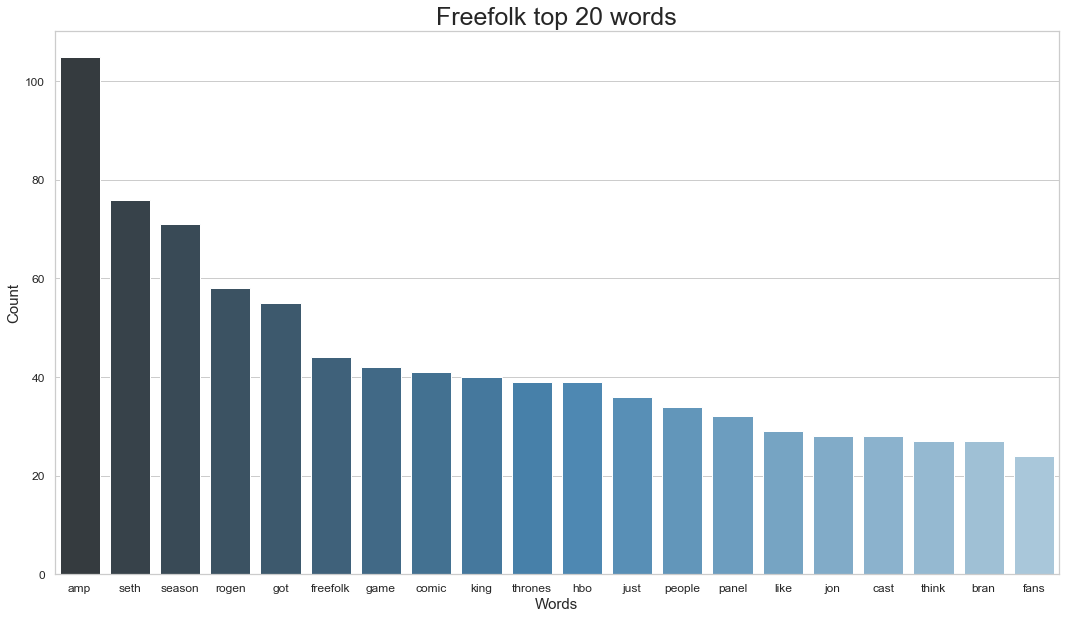

In [364]:
#visualization of most common words in freefolk
free_words = pd.DataFrame(word_counts.sort_values(ascending = False).head(20), columns=['count'])
plt.figure(figsize=(18,10))
sns.barplot(free_words.index, 'count', data=free_words, palette='Blues_d')
plt.title('Freefolk top 20 words', fontsize=25)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=12)

#### `pureasoiaf`

In [428]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer()

# Fitting the vectorizer on our training data
cvec.fit(pure_select_df['title'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [429]:
# Lets check the length of our data that is in a vectorized state
print('# of features: {}'.format(len(cvec.get_feature_names())))

# of features: 2334


In [430]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data
cvec.fit(pure_select_df['title'])

# and check out the length of the vectorized data after
print('# of features without stop words: {}'.format(len(cvec.get_feature_names())))

# of features without stop words: 2129


In [431]:
# Transforming using our fitted cvec.
# And converting the result to a DataFrame.
pure_title = pd.DataFrame(cvec.transform(pure_select_df['title']).todense(),
                       columns=cvec.get_feature_names())

In [432]:
# Which words appear the most in pure?
word_counts = pure_title.sum(axis=0)
print("Most common words in pureasoiaf")
word_counts.sort_values(ascending = False).head(20)

Most common words in pureasoiaf


spoilers    140
asoiaf       59
blood        46
amp          44
think        43
jon          41
did          41
just         40
books        35
read         35
does         33
adwd         32
chapter      32
twow         31
tyrion       30
westeros     28
time         26
question     26
favorite     26
series       25
dtype: int64

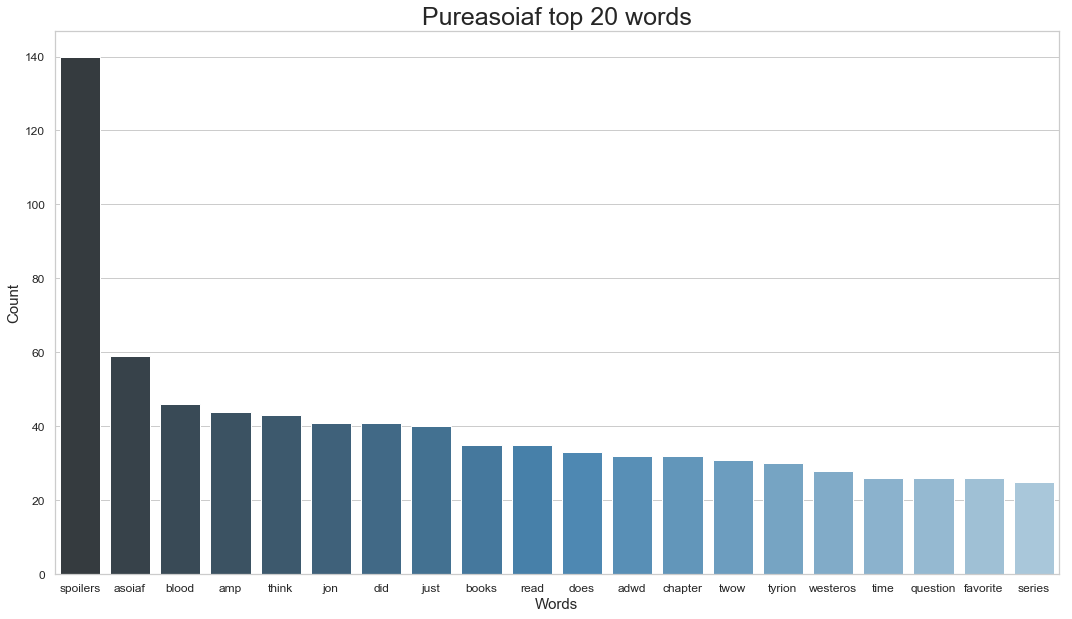

In [433]:
#visualization of most common words in pure
pure_words = pd.DataFrame(word_counts.sort_values(ascending = False).head(20), columns=['count'])
plt.figure(figsize=(18,10))
sns.barplot(pure_words.index, 'count', data=pure_words, palette='Blues_d')
plt.title('Pureasoiaf top 20 words', fontsize=25)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=12)

### Combining data from both subreddits

In [371]:
all_df = pd.concat([pure_select_df,free_select_df])
all_df.shape

(1977, 3)

In [372]:
all_df['subreddit'].value_counts()

freefolk      992
pureasoiaf    985
Name: subreddit, dtype: int64

### Convert `subreddit` into binary values

In [373]:
all_df['subreddit'] = all_df['subreddit'].map(dict(pureasoiaf=1, freefolk=0))
all_df['subreddit'].value_counts()

0    992
1    985
Name: subreddit, dtype: int64

### Run initial model

In [374]:
X = all_df['title']
y = all_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Baseline 

In [375]:
985/(985+992)

0.49822964087000504

Since there are 985 `pureasoiaf` posts out of a total of 1977 posts, we have a baseline slightly under 0.5.

#### CountVectorizer, Naive Bayes

In [376]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer()

# Fitting the vectorizer on our training data
cvec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [377]:
X_train = pd.DataFrame(cvec.transform(X_train).todense(),
                       columns=cvec.get_feature_names())

In [378]:
X_test = pd.DataFrame(cvec.transform(X_test).todense(),
                       columns=cvec.get_feature_names())

In [379]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [380]:
preds = nb.predict(X_test)

In [381]:
#define function for model performance
def performance(real,pred):
    print('Confusion matrix')
    print('\n')
    print(pd.DataFrame(confusion_matrix(real, pred), index=['Actual negative', 'Actual positive'], columns=['Predicted negative', 'Predicted positive']))
    tn, fp, fn, tp = confusion_matrix(real, pred).ravel()
    print('\n')
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print('\n')
    print('-'*60)
    print('\n')
    print('Classification report')
    print('\n')
    print(classification_report(real,pred))
    print('-'*60)
    print('\n')
    acc = accuracy_score(real,pred)
    print('Accuracy score: {}'.format(acc))

In [382]:
performance(y_test, preds)

Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 258                  40
Actual positive                  46                 250


True Negatives: 258
False Positives: 40
False Negatives: 46
True Positives: 250


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.85      0.87      0.86       298
           1       0.86      0.84      0.85       296

   micro avg       0.86      0.86      0.86       594
   macro avg       0.86      0.86      0.86       594
weighted avg       0.86      0.86      0.86       594

------------------------------------------------------------


Accuracy score: 0.8552188552188552


Using just a simple CountVectorizer and default Naive Bayes multinominal model, we are able to achieve an 85% accuracy, with 69 out of 594 posts classified wrongly - 46 `pureasoiaf` posts were classified erroneously and 40 `freefolk` posts were classified wrongly. This give us a good foundation to continue improving our predictions. 

### Further data preparation

#### Removing punctuation and capitalization

In [383]:
#lowercase words and strip punctuation except for apostrophe and dash
all_df['title_low'] = all_df['title'].map(lambda x: ''.join([y for y in list(x.lower()) if y in string.ascii_lowercase+" -'"]))
#strip dash as well, dash was not stripped in previous step as that would join word inappropriately eg: well-known to wellknown
all_df['title_low'] = all_df['title_low'].map(lambda x: x.replace('-',' '))

In [384]:
all_df.head()

,name,title,subreddit,title_low
0,t3_4g83fj,[No Spoilers] A Fair Warning. (ALL USERS PLEASE READ BEFORE POSTING),1,no spoilers a fair warning all users please read before posting
1,t3_cgc2aa,(Spoilers ADWD) This gave me all kinds of goosebumps,1,spoilers adwd this gave me all kinds of goosebumps
2,t3_cgad70,Why does Harrenhal have a Weirwood?,1,why does harrenhal have a weirwood
3,t3_cg1g6c,Does Stevron's death threaten the stability of house Frey.,1,does stevron's death threaten the stability of house frey
4,t3_cg21lz,Where was Tyrion before he arrived at Winterfell with Robert's Caravan?,1,where was tyrion before he arrived at winterfell with robert's caravan


#### Lemmatization

In [414]:
nlp = spacy.load('en')
def lemmatize(text):
    # Parse sentence into tokens
    doc = nlp(text)
    # Extract lemma for each token and join
    lemmatize_text = " ".join([token.lemma_ for token in doc])
    # pronouns are converted to -PRON-, which is not recognised as stopwords in count vectorizer and tfidf vectorizer, hence they need to be removed
    lemmatize_text = lemmatize_text.replace('-PRON-', '')
    return lemmatize_text

In [416]:
#form new column with lemmatized words
all_df['title_low_lemma'] = all_df['title_low'].apply(lemmatize)

In [417]:
all_df.head()

,name,title,subreddit,title_low,title_low_lemma
0,t3_4g83fj,[No Spoilers] A Fair Warning. (ALL USERS PLEASE READ BEFORE POSTING),1,no spoilers a fair warning all users please read before posting,no spoiler a fair warning all user please read before post
1,t3_cgc2aa,(Spoilers ADWD) This gave me all kinds of goosebumps,1,spoilers adwd this gave me all kinds of goosebumps,spoiler adwd this give all kind of goosebump
2,t3_cgad70,Why does Harrenhal have a Weirwood?,1,why does harrenhal have a weirwood,why do harrenhal have a weirwood
3,t3_cg1g6c,Does Stevron's death threaten the stability of house Frey.,1,does stevron's death threaten the stability of house frey,do stevron 's death threaten the stability of house frey
4,t3_cg21lz,Where was Tyrion before he arrived at Winterfell with Robert's Caravan?,1,where was tyrion before he arrived at winterfell with robert's caravan,where be tyrion before arrive at winterfell with robert 's caravan


#### Explore most common words

We will explore most common words in each subreddit again, but this time using the lemmatized version. 

#### `freefolk`

In [436]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer()

# Fitting the vectorizer on lemmatized data
cvec.fit(all_df[all_df['subreddit'] == 0]['title_low_lemma'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [437]:
# Lets check the length of our data that is in a vectorized state
print('# of features: {}'.format(len(cvec.get_feature_names())))

# of features: 1966


In [438]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data
cvec.fit(all_df[all_df['subreddit'] == 0]['title_low_lemma'])

# and check out the length of the vectorized data after
print('# of features without stop words: {}'.format(len(cvec.get_feature_names())))

# of features without stop words: 1793


In [439]:
# Transforming using our fitted cvec.
# And converting the result to a DataFrame.
free_title = pd.DataFrame(cvec.transform(all_df[all_df['subreddit'] == 0]['title_low_lemma']).todense(),
                       columns=cvec.get_feature_names())

In [440]:
# Which words appear the most in free?
word_counts = free_title.sum(axis=0)
print("Most common words in freefolk")
word_counts.sort_values(ascending = False).head(20)

Most common words in freefolk


dampd     87
season    80
seth      76
rogen     57
think     52
fan       46
king      44
throne    44
game      42
make      41
comic     41
hbo       37
panel     35
just      35
know      35
people    34
like      33
say       31
cast      28
bran      28
dtype: int64

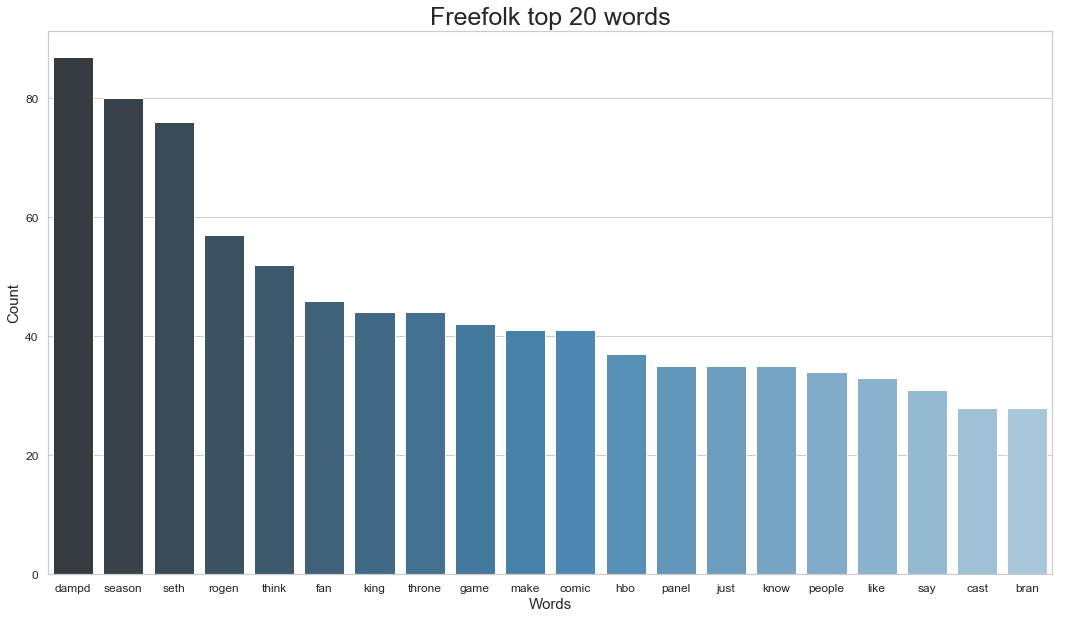

In [441]:
#visualization of most common words in free
free_words = pd.DataFrame(word_counts.sort_values(ascending = False).head(20), columns=['count'])
plt.figure(figsize=(18,10))
sns.barplot(free_words.index, 'count', data=free_words, palette='Blues_d')
plt.title('Freefolk top 20 words', fontsize=25)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=12)

#### `pureasoiaf`

In [442]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer()

# Fitting the vectorizer on lemmatized data
cvec.fit(all_df[all_df['subreddit'] == 1]['title_low_lemma'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [443]:
# Lets check the length of our data that is in a vectorized state
print('# of features: {}'.format(len(cvec.get_feature_names())))

# of features: 1983


In [445]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data
cvec.fit(all_df[all_df['subreddit'] == 1]['title_low_lemma'])

# and check out the length of the vectorized data after
print('# of features without stop words: {}'.format(len(cvec.get_feature_names())))

# of features without stop words: 1811


In [447]:
# Transforming using our fitted cvec.
# And converting the result to a DataFrame.
pure_title = pd.DataFrame(cvec.transform(all_df[all_df['subreddit'] == 1]['title_low_lemma']).todense(),
                       columns=cvec.get_feature_names())

In [448]:
# Which words appear the most in free?
word_counts = pure_title.sum(axis=0)
print("Most common words in pureasoiaf")
word_counts.sort_values(ascending = False).head(20)

Most common words in pureasoiaf


spoiler      147
asoiaf        58
book          55
read          53
think         52
character     46
chapter       46
blood         45
just          40
jon           39
dragon        34
king          32
question      31
twow          31
adwd          31
tyrion        30
time          27
theory        27
westero       27
amp           26
dtype: int64

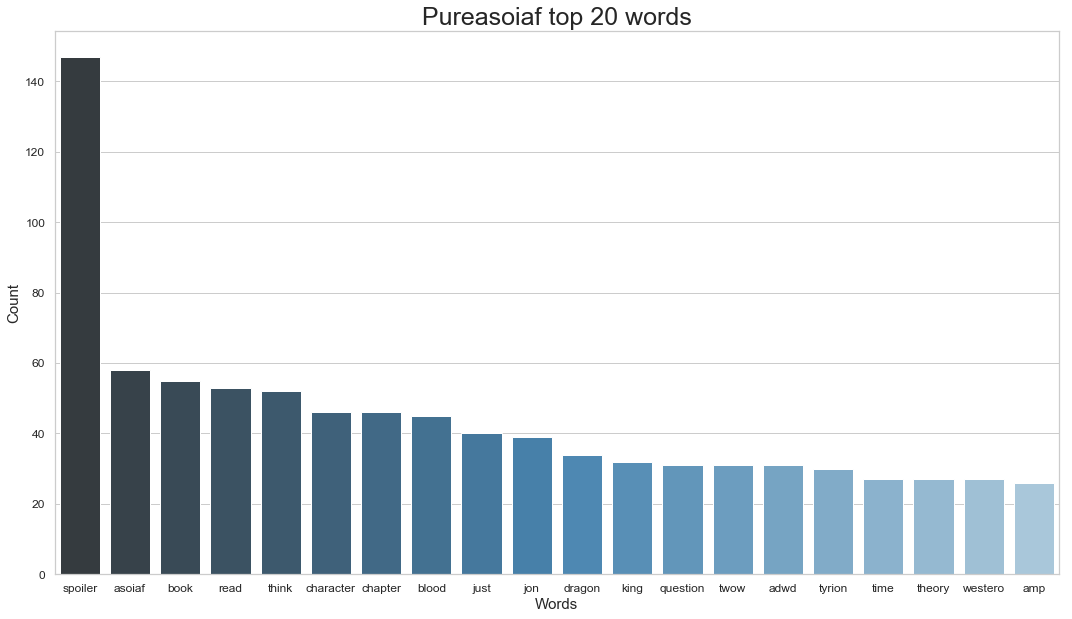

In [450]:
#visualization of most common words in pure
pure_words = pd.DataFrame(word_counts.sort_values(ascending = False).head(20), columns=['count'])
plt.figure(figsize=(18,10))
sns.barplot(pure_words.index, 'count', data=pure_words, palette='Blues_d')
plt.title('Pureasoiaf top 20 words', fontsize=25)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=12)

## Modelling

### Function for modelling

Let's create a function that can loop combinations of vectorizers and models to determine the most effective combination and best hyperparameters. 

In [385]:
#make a function for modelling
#define X, y, and parameters of vectorizer and model outside function

def predictor(vec_name_list, vectorizer_list, model_name_list, model_list, vec_params_list, model_params_list, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    scores_list = [] #stores all scores and params generated
    for i, model in enumerate(model_list): #loop to cycle through all models
        for j, vectorizer in enumerate(vectorizer_list): #loop to cycle through all vectorizer
            
            results = {} #stores scores and params for one model-vectorizer combination
            
            print("Evaluation of {} and {}".format(model, vectorizer))
            print('\n')
            pipe = Pipeline([#pipeline for vectorizer and model
            (vec_name_list[j], vectorizer(stop_words='english')), #j to match vectorizer being used, use stop words
            (model_name_list[i], model()),#i to match model being used
            ])
            
            results['model'] = model_name_list[i] #storing the features of this model-vec combination
            results['vectorizer'] = vec_name_list[j]
            
            params = {**vec_params_list[j], **model_params_list[i]} #combine params for this model-vec combination
    
            gridsearch = GridSearchCV(#gridsearch to determine best params for vectorizer
            pipe,
            params,
            cv=5,
            verbose=1,
            n_jobs=2,
            return_train_score=False)

            gridsearch.fit(X_train,y_train)
    
            print("Best CV score: %0.3f" % gridsearch.best_score_) #CV score based on best params
            
            results['cv'] = gridsearch.best_score_ #storing best CV score for this run
            
            print("Best parameters set:")
            best_parameters = gridsearch.best_estimator_.get_params()
            for param_name in sorted(params.keys()):
                print("\t%s: %r" % (param_name, best_parameters[param_name]))
                results['{}'.format(param_name)] = best_parameters[param_name]
            print('\n')#create space between results
            print('-'*60)
            print('\n')
    
            preds = gridsearch.best_estimator_.predict(X_test) #predict based on best estimator from gridsearch

            #below is same code as performance function, but repeated here so that tn, fp, etc can be stored in results
            print('Confusion matrix')
            print('\n')
            print(pd.DataFrame(confusion_matrix(y_test, preds), index=['Actual negative', 'Actual positive'], columns=['Predicted negative', 'Predicted positive']))
            tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
            print('\n')
            print("True Negatives: %s" % tn)
            print("False Positives: %s" % fp)
            print("False Negatives: %s" % fn)
            print("True Positives: %s" % tp)
            print('\n')
            print('-'*60)
            print('\n')
            print('Classification report')
            print('\n')
            print(classification_report(y_test, preds))
            print('-'*60)
            print('\n')
            acc = accuracy_score(y_test, preds)
            print('Accuracy score: {}'.format(acc))
            print('\n')
            print('='*60)
            print('='*60)
            print('\n')
            
            results['true_neg'] = tn #storing test predictions 
            results['false_pos'] = fp
            results['false_neg'] = fn
            results['true_pos'] = tp
            results['accuracy'] = acc
            
            scores_list.append(results) #storing all results of this vec-model combi to list of all combi results
    
    df = pd.DataFrame(scores_list) #make dataframe to see results of all combinations ran
    cols = df.columns.tolist() #make a list of all the columns in df
    col1 = ['model', 'vectorizer', 'accuracy', 'true_pos', 'false_pos', 'true_neg', 'false_neg',
            'cv', 'cvec__max_features', 'tvec__max_features'] #all columns that we want at start of dataframe
    col2 = [col for col in cols if col not in col1] #columns of model hyperparams, will change according to how many models and hyperparams
    df = df[col1+col2] #order dataframe columns in the way we want to see them
    
    return df #return dataframe to see results of all combinations ran

### Combination of vectorizers and models

We will use the following vectorizers:
- `CountVectorizer`
- `TfidfVectorizer`

And the following models:
- `MultinomialNB`
- `KNeighborsClassifier`
- `RandomForestClassifier`
- `LogisticRegression`

In [451]:
X = all_df['title_low_lemma']
y = all_df['subreddit']


vec_name_list = [
    'cvec',
    'tvec'
]

vectorizer_list = [
    CountVectorizer,
    TfidfVectorizer
]

model_name_list = [
    'nb',
    'knn',
    'rfc',
    'lr'
]

model_list = [
    MultinomialNB,
    KNeighborsClassifier,
    RandomForestClassifier,
    LogisticRegression
]

vec_params_list = [
    {'cvec__max_features': range(100,2400,100)},
    {'tvec__max_features': range(100,2400,100)}
]

nb_params = {
    'nb__alpha': np.linspace(0,1,num=11)
}

knn_params = {
    'knn__n_neighbors': range(1,50,10),
    'knn__metric': ['euclidean','manhattan']
}

rfc_params = {
    'rfc__n_estimators': range(50,100,10),
    'rfc__criterion': ['gini','entropy']
}

lr_params = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': np.logspace(-4, 0, 40)
}

model_params_list = [
    nb_params,
    knn_params,
    rfc_params,
    lr_params
]

predictor(vec_name_list, vectorizer_list, model_name_list, model_list, vec_params_list, model_params_list, X, y)

Evaluation of <class 'sklearn.naive_bayes.MultinomialNB'> and <class 'sklearn.feature_extraction.text.CountVectorizer'>


Fitting 5 folds for each of 253 candidates, totalling 1265 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 221 tasks      | elapsed:    7.4s
[Parallel(n_jobs=2)]: Done 1265 out of 1265 | elapsed:   19.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best CV score: 0.845
Best parameters set:
	cvec__max_features: 2100
	nb__alpha: 0.6000000000000001


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 250                  48
Actual positive                  50                 246


True Negatives: 250
False Positives: 48
False Negatives: 50
True Positives: 246


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.83      0.84      0.84       298
           1       0.84      0.83      0.83       296

   micro avg       0.84      0.84      0.84       594
   macro avg       0.84      0.84      0.84       594
weighted avg       0.84      0.84      0.84       594

------------------------------------------------------------


Accuracy score: 0.835016835016835




Evaluation of <class 'sklearn.naive_bayes.Multinom

[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done 1265 out of 1265 | elapsed:   13.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best CV score: 0.852
Best parameters set:
	nb__alpha: 0.6000000000000001
	tvec__max_features: 2100


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 253                  45
Actual positive                  58                 238


True Negatives: 253
False Positives: 45
False Negatives: 58
True Positives: 238


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.81      0.85      0.83       298
           1       0.84      0.80      0.82       296

   micro avg       0.83      0.83      0.83       594
   macro avg       0.83      0.83      0.83       594
weighted avg       0.83      0.83      0.83       594

------------------------------------------------------------


Accuracy score: 0.8265993265993266




Evaluation of <class 'sklearn.neighbors.classific

[Parallel(n_jobs=2)]: Done 400 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done 1150 out of 1150 | elapsed:   40.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best CV score: 0.712
Best parameters set:
	cvec__max_features: 200
	knn__metric: 'manhattan'
	knn__n_neighbors: 1


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 171                 127
Actual positive                  42                 254


True Negatives: 171
False Positives: 127
False Negatives: 42
True Positives: 254


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.80      0.57      0.67       298
           1       0.67      0.86      0.75       296

   micro avg       0.72      0.72      0.72       594
   macro avg       0.73      0.72      0.71       594
weighted avg       0.73      0.72      0.71       594

------------------------------------------------------------


Accuracy score: 0.7154882154882155




Evaluation of <class 'sklearn.nei

[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done 1114 tasks      | elapsed:   38.5s
[Parallel(n_jobs=2)]: Done 1147 out of 1150 | elapsed:   41.2s remaining:    0.1s
[Parallel(n_jobs=2)]: Done 1150 out of 1150 | elapsed:   41.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best CV score: 0.736
Best parameters set:
	knn__metric: 'euclidean'
	knn__n_neighbors: 41
	tvec__max_features: 2100


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 294                   4
Actual positive                 163                 133


True Negatives: 294
False Positives: 4
False Negatives: 163
True Positives: 133


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.64      0.99      0.78       298
           1       0.97      0.45      0.61       296

   micro avg       0.72      0.72      0.72       594
   macro avg       0.81      0.72      0.70       594
weighted avg       0.81      0.72      0.70       594

------------------------------------------------------------


Accuracy score: 0.7188552188552189




Evaluation of <class 'sklearn.en

[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   37.5s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 1150 out of 1150 | elapsed:  2.1min finished


Best CV score: 0.800
Best parameters set:
	cvec__max_features: 1400
	rfc__criterion: 'entropy'
	rfc__n_estimators: 50


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 259                  39
Actual positive                  82                 214


True Negatives: 259
False Positives: 39
False Negatives: 82
True Positives: 214


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.76      0.87      0.81       298
           1       0.85      0.72      0.78       296

   micro avg       0.80      0.80      0.80       594
   macro avg       0.80      0.80      0.80       594
weighted avg       0.80      0.80      0.80       594

------------------------------------------------------------


Accuracy score: 0.7962962962962963




Evaluation of <class 'sklearn.

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   31.6s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 1150 out of 1150 | elapsed:  1.8min finished


Best CV score: 0.808
Best parameters set:
	rfc__criterion: 'entropy'
	rfc__n_estimators: 80
	tvec__max_features: 1300


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 253                  45
Actual positive                  78                 218


True Negatives: 253
False Positives: 45
False Negatives: 78
True Positives: 218


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.76      0.85      0.80       298
           1       0.83      0.74      0.78       296

   micro avg       0.79      0.79      0.79       594
   macro avg       0.80      0.79      0.79       594
weighted avg       0.80      0.79      0.79       594

------------------------------------------------------------


Accuracy score: 0.7929292929292929




Evaluation of <class 'sklearn.

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 392 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 1892 tasks      | elapsed:   21.0s
[Parallel(n_jobs=2)]: Done 4392 tasks      | elapsed:   48.0s
[Parallel(n_jobs=2)]: Done 7892 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 9200 out of 9200 | elapsed:  1.8min finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best CV score: 0.826
Best parameters set:
	cvec__max_features: 2100
	lr__C: 0.09426684551178854
	lr__penalty: 'l2'


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 257                  41
Actual positive                  64                 232


True Negatives: 257
False Positives: 41
False Negatives: 64
True Positives: 232


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.80      0.86      0.83       298
           1       0.85      0.78      0.82       296

   micro avg       0.82      0.82      0.82       594
   macro avg       0.83      0.82      0.82       594
weighted avg       0.83      0.82      0.82       594

------------------------------------------------------------


Accuracy score: 0.8232323232323232




Evaluation of <class 'sklearn.lin

[Parallel(n_jobs=2)]: Done 592 tasks      | elapsed:    7.5s
[Parallel(n_jobs=2)]: Done 2692 tasks      | elapsed:   37.6s
[Parallel(n_jobs=2)]: Done 6192 tasks      | elapsed:  1.3min


Best CV score: 0.834
Best parameters set:
	lr__C: 0.19144819761699575
	lr__penalty: 'l2'
	tvec__max_features: 2100


------------------------------------------------------------


Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 258                  40
Actual positive                  60                 236


True Negatives: 258
False Positives: 40
False Negatives: 60
True Positives: 236


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.81      0.87      0.84       298
           1       0.86      0.80      0.83       296

   micro avg       0.83      0.83      0.83       594
   macro avg       0.83      0.83      0.83       594
weighted avg       0.83      0.83      0.83       594

------------------------------------------------------------


Accuracy score: 0.8316498316498316






[Parallel(n_jobs=2)]: Done 9200 out of 9200 | elapsed:  1.9min finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,model,vectorizer,accuracy,true_pos,false_pos,true_neg,false_neg,cv,cvec__max_features,tvec__max_features,knn__metric,knn__n_neighbors,lr__C,lr__penalty,nb__alpha,rfc__criterion,rfc__n_estimators
0,nb,cvec,0.835017,246,48,250,50,0.845264,2100.0,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN
1,nb,tvec,0.826599,238,45,253,58,0.851772,NaN,2100.0,NaN,NaN,NaN,NaN,0.6,NaN,NaN
2,knn,cvec,0.715488,254,127,171,42,0.712220,200.0,NaN,manhattan,1.0,NaN,NaN,NaN,NaN,NaN
3,knn,tvec,0.718855,133,4,294,163,0.736081,NaN,2100.0,euclidean,41.0,NaN,NaN,NaN,NaN,NaN
4,rfc,cvec,0.796296,214,39,259,82,0.799711,1400.0,NaN,NaN,NaN,NaN,NaN,NaN,entropy,50.0
5,rfc,tvec,0.792929,218,45,253,78,0.808388,NaN,1300.0,NaN,NaN,NaN,NaN,NaN,entropy,80.0
6,lr,cvec,0.823232,232,41,257,64,0.825741,2100.0,NaN,NaN,NaN,0.094267,l2,NaN,NaN,NaN
7,lr,tvec,0.831650,236,40,258,60,0.834418,NaN,2100.0,NaN,NaN,0.191448,l2,NaN,NaN,NaN


### Evaluation of vectorizer and model performance

Based on the results, the `KNeighborsClassifier` performed the worst, with about 71% accuracy. 

The `RandomForestClassifier` performed better with 79% accuracy.  

The `MultinomialNB` and `LogisticRegression` similarly, with about 82%-83% accuracy for their various combinations. 

We will select the `LogisticRegression`-`TfidVectorizer` combination for interpretability.

## Logistic model analysis

### Fitting data to `TfidfVectorizer` and `LogisticRegresssion`

In [452]:
tvec = TfidfVectorizer(stop_words='english')
lr = LogisticRegression()

X = all_df['title_low_lemma']
y = all_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [453]:
tvec.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [454]:
X_train = pd.DataFrame(tvec.transform(X_train).todense(), #transform to dense 
                       columns=tvec.get_feature_names())

X_test = pd.DataFrame(tvec.transform(X_test).todense(), #transform to dense
                       columns=tvec.get_feature_names())

In [455]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### `GridSearchCV` to determine best hyperparameters

In [456]:
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 0, 40)
}

lr_gridsearch = GridSearchCV(#gridsearch to determine best params for model
            lr,
            lr_params,
            cv=5,
            verbose=1,
            n_jobs=2,
            return_train_score=False)

lr_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    3.8s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-04, 1.26638e-04, 1.60372e-04, 2.03092e-04, 2.57191e-04,
       3.25702e-04, 4.12463e-04, 5.22335e-04, 6.61474e-04, 8.37678e-04,
       1.06082e-03, 1.34340e-03, 1.70125e-03, 2.15443e-03, 2.72833e-03,
       3.45511e-03, 4.37548e-03, 5.54102e-... 2.42446e-01, 3.07029e-01,
       3.88816e-01, 4.92388e-01, 6.23551e-01, 7.89652e-01, 1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=1)

In [457]:
lr_gridsearch.best_params_

{'C': 1.0, 'penalty': 'l2'}

### Predictions

In [458]:
preds = lr_gridsearch.best_estimator_.predict(X_test)

In [459]:
performance(y_test,preds)

Confusion matrix


                 Predicted negative  Predicted positive
Actual negative                 257                  45
Actual positive                  54                 238


True Negatives: 257
False Positives: 45
False Negatives: 54
True Positives: 238


------------------------------------------------------------


Classification report


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       302
           1       0.84      0.82      0.83       292

   micro avg       0.83      0.83      0.83       594
   macro avg       0.83      0.83      0.83       594
weighted avg       0.83      0.83      0.83       594

------------------------------------------------------------


Accuracy score: 0.8333333333333334


### Analysis of coefficients

In [460]:
#create dataframe of features with their corresponding coefficient values
coef_df = pd.DataFrame({'feature':X_train.columns,'coef':lr_gridsearch.best_estimator_.coef_[0]})
coef_df.sort_values(by=['coef'], inplace=True, ascending=False)

#### Top 20 words that increase probability of `pureasoiaf`

In [461]:
coef_df.head(20)

,feature,coef
2001,spoiler,3.858415
131,asoiaf,2.589223
347,chapter,1.999415
238,blood,1.931786
1701,read,1.745943
251,book,1.623157
2133,theory,1.610682
2312,westero,1.597147
34,adwd,1.585463
2195,twow,1.471229


$$log odds = \log \left({p\over 1-p}\right) = \beta_0 + \beta_1x + \beta_2x + ... + \beta_nx$$

Words with positive coefficients increase the log odds of the response and thus increase the probability that the post will be classified as `pureasoiaf`.

#### Comparison with `asoiaf` most-common word list

We had compiled a list of words that are most common in `asoiaf`. Let us now compare that with the coefficient list. These words below are both the most common words in `asoiaf` and also most impactful in determining a prediction of `asoiaf`.

In [462]:
#code to match with most common words in asoiaf
coef_df.head(20)[coef_df.head(20)['feature'].isin(pure_words.index)]

,feature,coef
2001,spoiler,3.858415
131,asoiaf,2.589223
347,chapter,1.999415
238,blood,1.931786
1701,read,1.745943
251,book,1.623157
2133,theory,1.610682
2312,westero,1.597147
34,adwd,1.585463
2195,twow,1.471229


These words below are not in the most common word list in `asoiaf` but were impactful in determining a prediction of `asoiaf`.

In [463]:
#code to find words in coef_df that are not in most common words in asoiaf
coef_df.head(20)[~coef_df.head(20)['feature'].isin(pure_words.index)]

,feature,coef
1810,robert,1.465668
775,favorite,1.300643
1019,house,1.289615
1601,pov,1.243600
915,grrm,1.204838
20,acok,1.157014
2015,stanni,1.142262
1183,knight,1.111503


The model was intelligent enough to pick out the words 'grrm' (George R. R. Martin, the author of the book series) and 'acok' (A Clash of Kings, one of the book titles) as important in predicting `asoiaf`, which is dedicated to books. Another important word to the books is 'pov' (point of view), as each chapter in the books is written from a different character's point of view. 

#### Top 20 words that increase probability of `freefolk`

In [464]:
coef_df.tail(20).sort_values(by=['coef'])

,feature,coef
512,dampd,-2.839063
1872,season,-2.459048
1898,seth,-2.368611
761,fan,-2.073256
405,comic,-1.942996
1513,panel,-1.638931
1789,rfreefolk,-1.630570
1814,rogen,-1.572112
951,hbo,-1.529073
325,cast,-1.456859


$$log odds = \log \left({p\over 1-p}\right) = \beta_0 + \beta_1x + \beta_2x + ... + \beta_nx$$

Words with negative coefficients decrease the log odds of the response and thus decrease the probability that the post will be classified as `pureasoiaf`. In other words, increasing the probability that the post will be classified as `freefolk`.

#### Comparison with `freefolk` most-common word list

We had compiled a list of words that are most common in `freefolk`. Let us now compare that with the coefficient list. These words below are both the most common words in `freefolk` and also most impactful in determining a prediction of `freefolk`.

In [465]:
#code to match with most common words in freefolk
coef_df.tail(20)[coef_df.tail(20)['feature'].isin(free_words.index)]

,feature,coef
325,cast,-1.456859
951,hbo,-1.529073
1814,rogen,-1.572112
1513,panel,-1.638931
405,comic,-1.942996
761,fan,-2.073256
1898,seth,-2.368611
1872,season,-2.459048
512,dampd,-2.839063


These words below are not in the most common word list in `freefolk` but were impactful in determining a prediction of `freefolk`.

In [466]:
#code to negate match with most common words in freefolk
coef_df.tail(20)[~coef_df.tail(20)['feature'].isin(free_words.index)]

,feature,coef
680,ending,-0.980711
673,emmy,-0.981730
402,come,-1.060523
949,hate,-1.096941
244,bobby,-1.099775
1868,sdcc,-1.137287
839,freefolk,-1.199591
848,fuck,-1.219319
1180,kneeler,-1.280997
1638,promise,-1.398602


The model was able to correctly assign a significantly negative coefficient to 'emmy', which appeared because the Emmy nominations of various Game of Thrones cast members were discussed. Naturally, that word doesn't appear in `pureasoiaf` at all as that subreddit is dedicated to the books. The name 'bobby' also has high predictive power, which is probably because it is contrasted with 'robert' in `pureasoiaf`. Both names refer to the same character, King Robert, and the use of 'bobby' means the model could detect the difference in language formality in the two subreddits. The use of profanity as a distinguishing feature was also caught by the model as it assigned high predictive power to the word 'fuck'. 

Text(0, 0.5, 'Words')

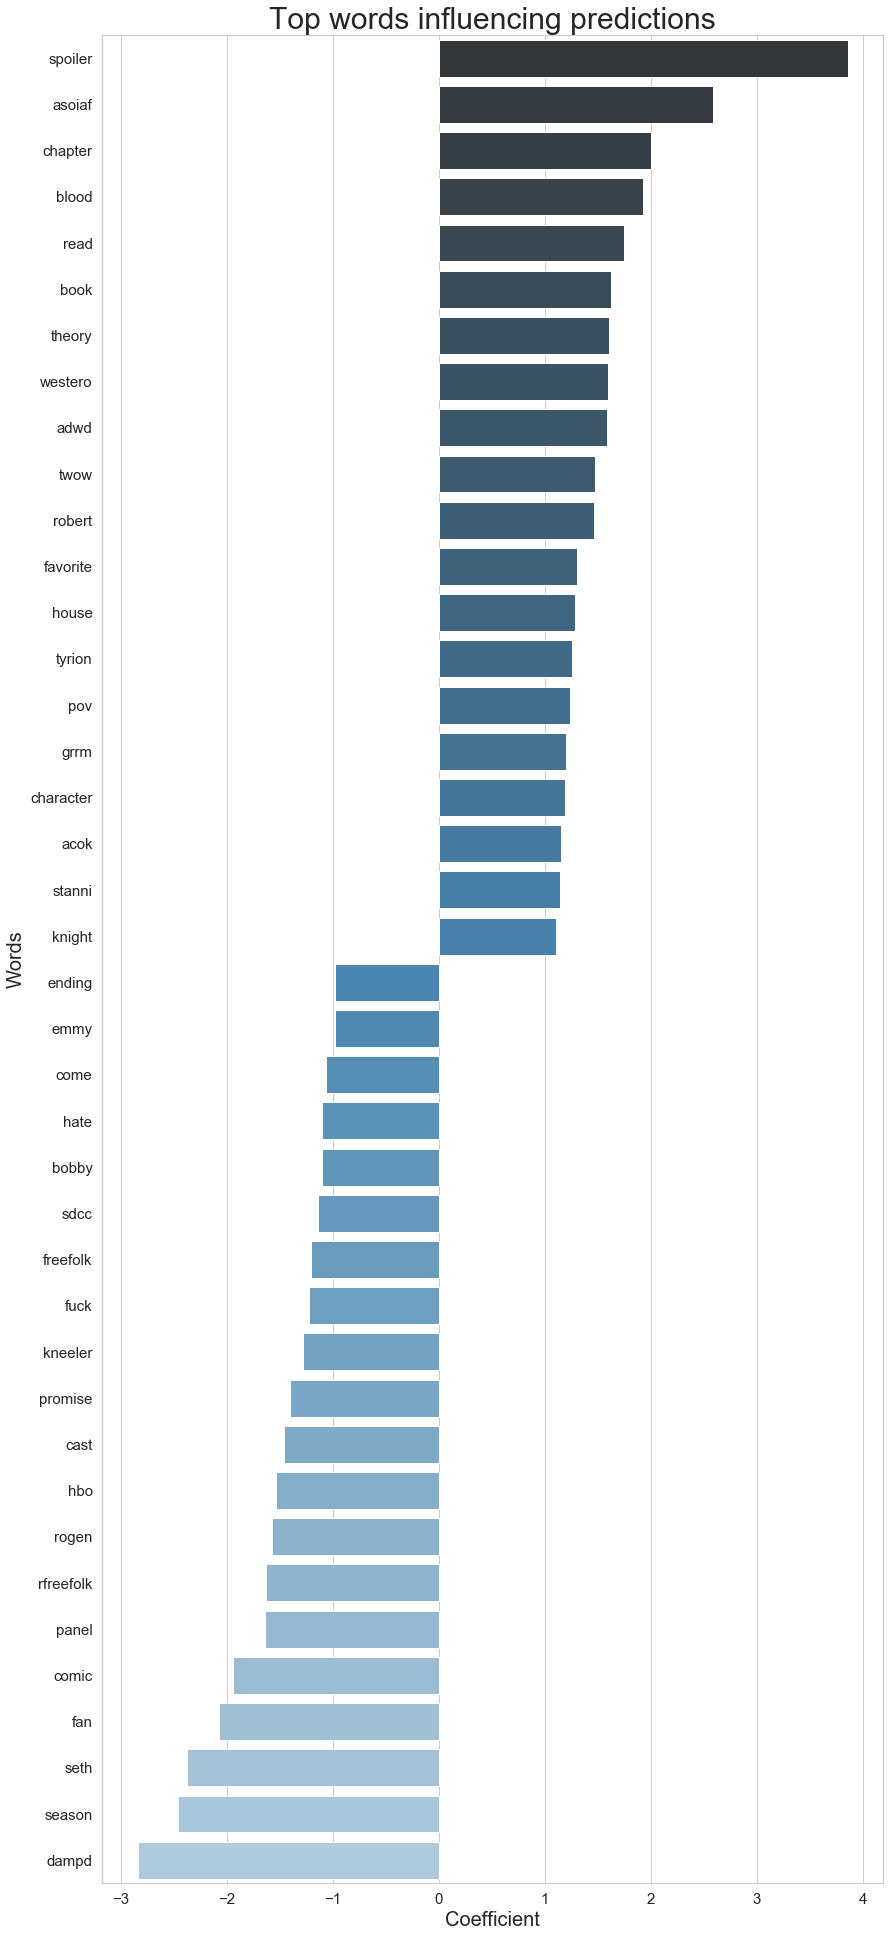

In [467]:
#visualize the top 20 words determining asoiaf and top 20 words determining freefolk
top_coef_df = pd.concat([coef_df.head(20), coef_df.tail(20)])
sns.set(style='whitegrid',rc={"figure.figsize": (14, 34)})
sns.barplot(y='feature',x='coef', data=top_coef_df, palette='Blues_d')
plt.title('Top words influencing predictions', fontsize=30)
plt.tick_params(labelsize=15)
plt.xlabel('Coefficient', fontsize=20)
plt.ylabel('Words', fontsize=20)

### Misclassified posts analysis

Redo the `train_test_split` to get unvectorized posts.

In [468]:
X = all_df['title_low_lemma']
y = all_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [469]:
test_df = pd.concat([pd.DataFrame(X_test),pd.DataFrame(y_test)],axis=1)#combine X_test, y_test
test_df = test_df.reset_index() #reset index so that can join predictions

In [470]:
test_df = pd.concat([test_df,pd.DataFrame(preds,columns=['prediction'])],axis=1) #combine with predictions
test_df.head()

,index,title_low_lemma,subreddit,prediction
0,842,finally get to watch the last watch furdik be speak some truth,0,0
1,904,the first be way big and angry,0,0
2,678,if the dany chapter at the end of a dance with dragon do not happen what would the state of this sub be,1,1
3,351,go through the world of ice and fire and this be not make much sense to,1,1
4,120,kneeler in a nutshell,0,0


Check which posts were predicted wrongly.

In [471]:
misclass_df = test_df[test_df['subreddit'] != test_df['prediction']] #subreddit doesnt match prediction
misclass_df.head()

,index,title_low_lemma,subreddit,prediction
6,70,want to do an unpopular prediction thread,1,0
8,56,cyvasse,1,0
9,967,be the sand snake as kick ass in the bock as be on the show,0,1
20,867,hope this format be not dead yet,0,1
28,439,warn to anyone interested in buy a new a clash of king paperback,1,0


In [472]:
false_pos_df = misclass_df[misclass_df['prediction'] == 1]
false_neg_df = misclass_df[misclass_df['prediction'] == 0]
print(false_pos_df.shape[0]) # to check if number matches false pos 
print(false_neg_df.shape[0]) #to check if number matches false neg

45
54


#### False positives

In [473]:
pd.options.display.max_colwidth =140
false_pos_df

,index,title_low_lemma,subreddit,prediction
9,967,be the sand snake as kick ass in the bock as be on the show,0,1
20,867,hope this format be not dead yet,0,1
33,345,just take the beating dude,0,1
44,333,a khal who can not ride be no khal,0,1
69,805,can not wait till grrm die and get this masterpiece,0,1
78,629,i just can not help,0,1
114,422,oh how kind of,0,1
127,752,and then cry immediately after,0,1
149,193,have come up with another solution to jon 's heritage issue if dany would not have like to marry or kill could have name a member of...,0,1
163,432,jon snow vs the army of the dead,0,1


False positives are broadly in two categories:
- Posts that use character names (Rhaegar, Targaryen) and places (Blackwater). These terms are likelier to be in the `pureasoiaf` subreddit that discusses intricate plot developments.
- The model was also misled by some `freefolk` posts that used 'grrm' (George R. R. Martin, the author of the books) and 'robert', which is more common in `pureasoiaf` while 'bobby' is more common in `freefolk`.  
- Short posts with fewer than five words. Perhaps there was too little information for the model to form an informed prediction. 

#### False negatives

In [474]:
false_neg_df

,index,title_low_lemma,subreddit,prediction
6,70,want to do an unpopular prediction thread,1,0
8,56,cyvasse,1,0
28,439,warn to anyone interested in buy a new a clash of king paperback,1,0
30,651,be this how picture this fight,1,0
31,211,will arya ever become no one,1,0
37,111,maynard plumms true identity,1,0
45,316,mindblowe,1,0
48,426,in term of the end how much do actually care who sit the throne,1,0
60,382,man got to love egg and insolent know all humour to think that this be the kid aemon targaryen talk about in deathbed a hundred year...,1,0
68,69,winter be come,1,0


It is more difficult to discern patterns in the false negatives. While there are posts that are too short to give useful information, other posts appear quite easy to categorize as `asoiaf` posts, at least to the human eye. For example, there are a few posts mentioning books.  

## Conclusion

### Findings

- After experimenting with several models, we achieved 84.5% accuracy in predicting which subreddit a post came from using the `LogisticRegression`-`TfidfVectorizer` combination. 
- This model was chosen for its interpretability and we found that the model was intelligent enough to pick certain words that had high predictive power even though they are not the most common words in their subreddits.

### Limitations

- Many of the posts, especially in `freefolk`, were memes and did not contain text in the post's body for analysis. We could rely only on the titles of the posts. 
- The model had 45 false positives (`freefolk` wrongly classified as `pureasoiaf`) and 54 false negatives (`pureasoiaf` wrongly classified as `freefolk`). The higher number of false negatives than false positives is troubling as the consequences of false negatives are potentially greater. For example, if we were to advertise book or television content to the users based on predictions of which group they belong to, `freefolk` users will not have any issues receiving book content, but `pureasoiaf` users will be riled up receiving television content, which they have sworn off. They will also be afflicted by spoilers, as the television series' plot has gone beyond the books. 

### Further exploration

- Explore more models which is more sensitive (has a better recall or true positive rate) as it is arguably more important to have sensitivity than precision in our case. 
- Move beyond the Reddit API, which allows just 1,000 posts, and collect larger datasets to see if that can improve performance.
- Compare more Game of Thrones-related subreddits to see if results hold up across different fanbases. 
- Collect another 1,000 posts each from subreddits during a different time period to see if results differ. This is particularly the case for `freefolk`, which was very much influenced by the San Diego Comic Convention and Emmy Awards nomination during the time of data collection. 